# Case 1

In [2]:
import pandas as pd
import numpy as np
from math import floor, ceil, log2
from scipy.fft import fft, fftshift
from scipy.signal import lfilter, freqs, filtfilt, iirfilter, windows
import matplotlib.pyplot as plt
import seaborn as sns
from mplcursors import cursor
import os

path_1 = './part_1'

## Carregar dados

In [3]:
signals_dict = {}

In [4]:
class Sensor:
    def __init__(self, path, filename):
        self.filename = filename
        self.epoch, self.step, self.sensor = filename[:-4].split('-')
        self.step = float(self.step)/1000
        self.time_signals = pd.read_csv(path +'/'+filename)
        self.freq_signals = pd.DataFrame()
        self.filt_time_signals = pd.DataFrame()
        self.filt_freq_signals = pd.DataFrame()
        self.get_time_signal()

    def get_time_signal(self):
        time_array = np.arange(0,len(self.time_signals))
        time_array = time_array*self.step
        self.time_signals['time'] = time_array
        self.freq_step = 1/max(self.time_signals['time'])
        # ajustar numero impar para simetria da fft
        if not(len(self.time_signals) % 2):
            self.time_signals = self.time_signals.iloc[:-1]
        pass

    def fft(self,time_signals):
        freq_signals = pd.DataFrame()
        freq_array = np.arange(0,len(time_signals))*self.freq_step
        freq_array = freq_array - freq_array[floor(len(freq_array)/2)]
        freq_signals['freq'] = freq_array

        # janelamento de Hamming (redução de leakage)
        hamm = windows.hamming(len(freq_array))

        for c in ['x','y','z']:
            data = np.array(time_signals[c])
            data = data-data.mean()
            time_signals[c] = np.multiply(data,hamm)
            fft_array = fft(data, norm='forward')
            fft_array = fftshift(fft_array)
            # calculo de amplitude e fase
            abs_array = np.abs(fft_array)
            phase_array = np.angle(fft_array)
            freq_signals[c] = abs_array

        fig, axes = plt.subplots(3, 2, figsize=(15, 5), sharey=False)
        g = sns.lineplot(time_signals,x='time',y='x',ax=axes[0,0])
        g = sns.lineplot(freq_signals,x='freq',y='x',ax=axes[0,1])
        g = sns.lineplot(time_signals,x='time',y='y',ax=axes[1,0])
        g = sns.lineplot(freq_signals,x='freq',y='y',ax=axes[1,1])
        g = sns.lineplot(time_signals,x='time',y='z',ax=axes[2,0])
        g = sns.lineplot(freq_signals,x='freq',y='z',ax=axes[2,1])
        axes[0,0].set_title('{} - time'.format(self.sensor))
        axes[0,1].set_title('{} - frequency'.format(self.sensor))

        cursor(hover=True)
        plt.show(block=False)

        return freq_signals

    def filter(self, time_signals):
        # filtro anti aliasing
        wn = max(self.freq_signals['freq'])/2 # Nyquist freq
        b, a = iirfilter(8, wn*2*np.pi/2, btype='lowpass', ftype='butter', analog=False)
        filt_time_signals = pd.DataFrame()
        filt_time_signals['time'] = time_signals['time'] 
        for c in ['x','y','z']:
            filt_data = filtfilt(b,a,time_signals[c] - time_signals[c].mean())
            filt_time_signals[c] = filt_data

        w, h = freqs(b, a, 100000)
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.semilogx(w / (2*np.pi), 20 * np.log10(np.maximum(abs(h), 1e-5)))
        ax.set_title('Filter')
        ax.set_xlabel('Frequency [Hz]')
        ax.set_ylabel('Amplitude [dB]')
        ax.grid(which='both', axis='both')

        cursor(hover=True)
        plt.show(block=False)

        return filt_time_signals
    
    def get_harmonics(self, filt_freq_signals):
        filt_freq_signals = filt_freq_signals[floor(len(filt_freq_signals)/2):]
        max_freq_id = len(filt_freq_signals)
        # encontra menor frequencia de pico de amplitude
        for c in ['x','y','z']:
            id = np.argmax(filt_freq_signals[c])
            if max_freq_id > id:
                max_freq_id = id

        # varre multiplos da frequência (+-10*df) até Nyquist
        harmonics = pd.DataFrame()
        i = 1
        while max_freq_id*i <= len(filt_freq_signals)/4:
            amps = []
            for c in ['x','y','z']:
                id = max_freq_id*i
                freq = filt_freq_signals['freq'].iloc[id]
                amps = amps + [max(filt_freq_signals[c].iloc[id-10:id+11])]
            amps = amps + [freq] + [i]
            aux_df = pd.DataFrame(data=[amps], columns=['x','y','z','freq','mult'])
            harmonics = pd.concat([harmonics,aux_df], axis=0)
            i+=1
        
        self.get_harmonics = harmonics
        return harmonics

## Executar analise

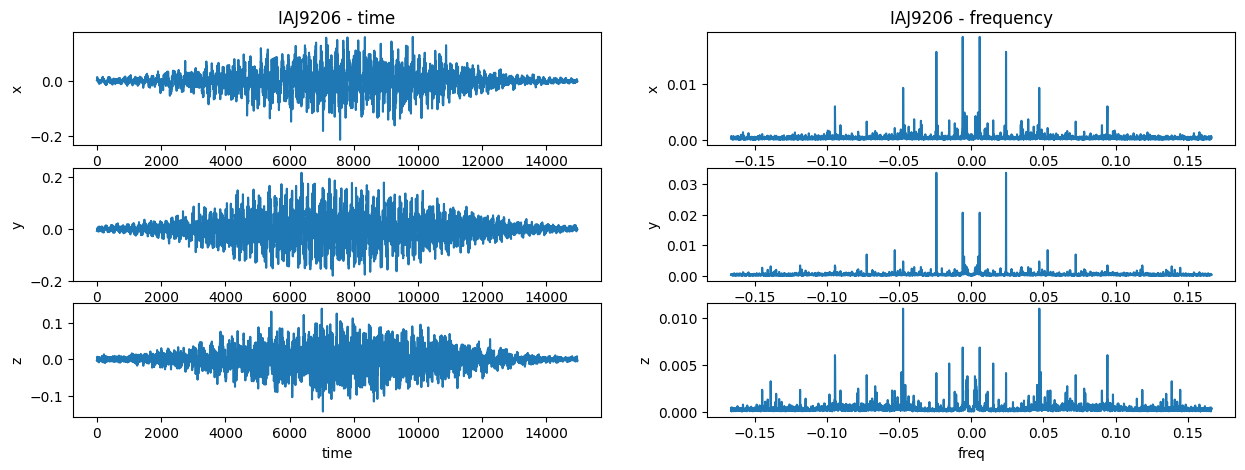

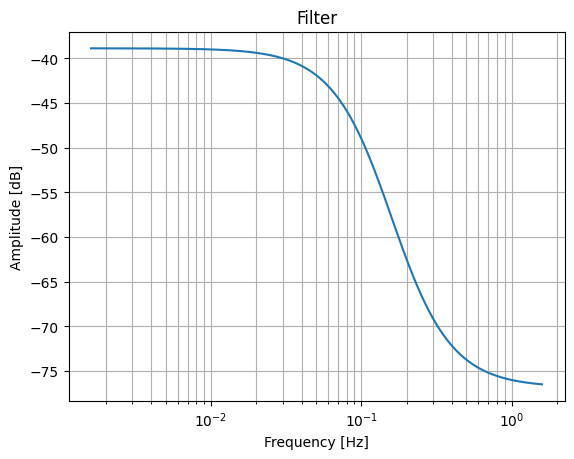

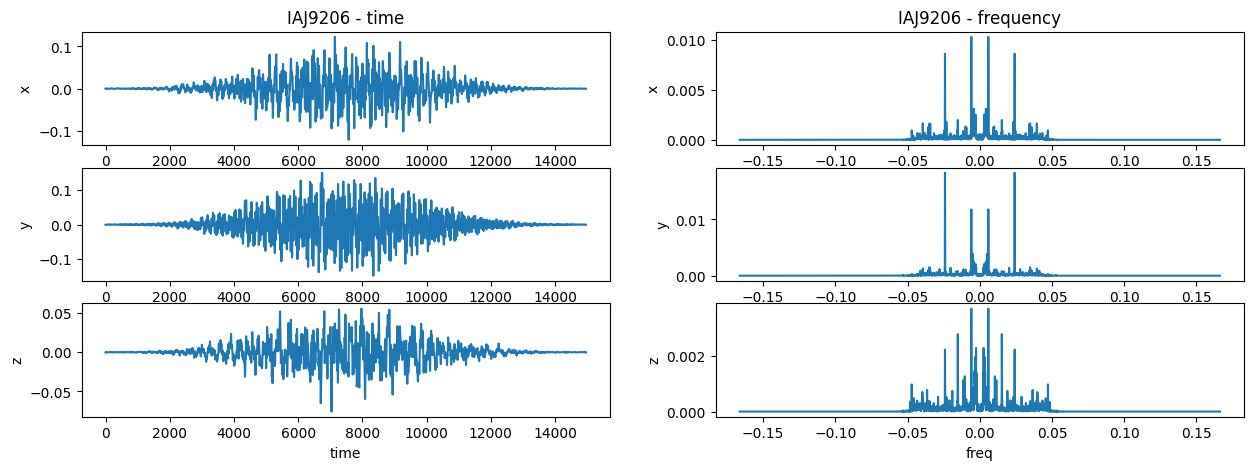

          x         y         z      freq  mult
0  0.010311  0.011772  0.003698  0.005880     1
0  0.000882  0.001122  0.001128  0.011759     2
0  0.000474  0.000268  0.000130  0.017639     3
0  0.008624  0.018304  0.002227  0.023519     4
0  0.000394  0.000641  0.000532  0.029398     5
0  0.001643  0.001513  0.000374  0.035278     6
0  0.000625  0.000896  0.000299  0.041158     7


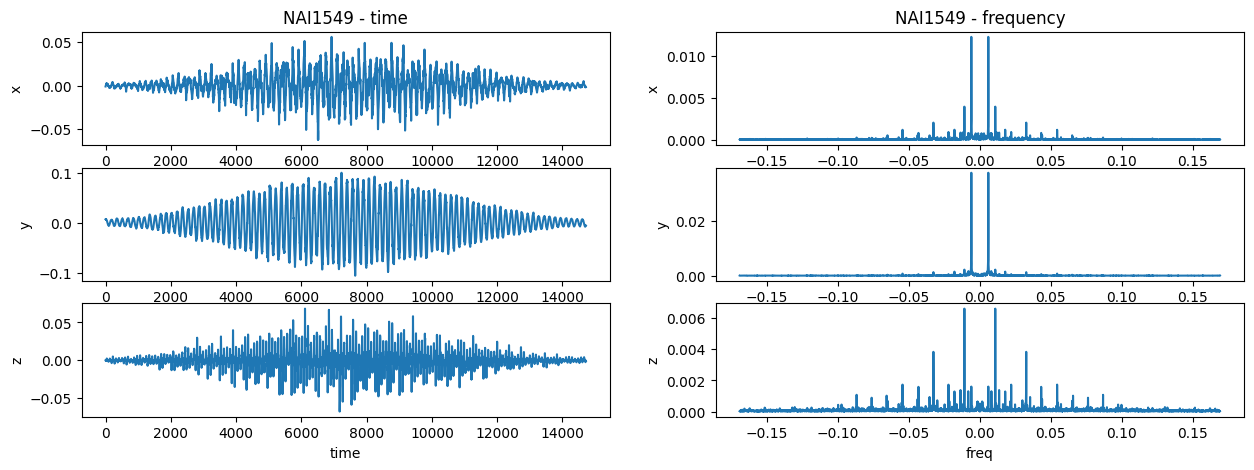

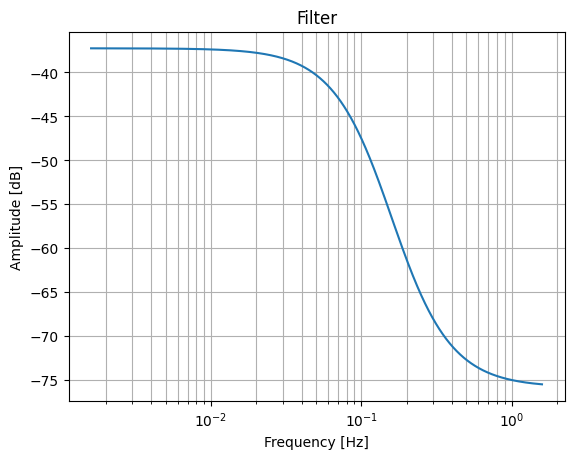

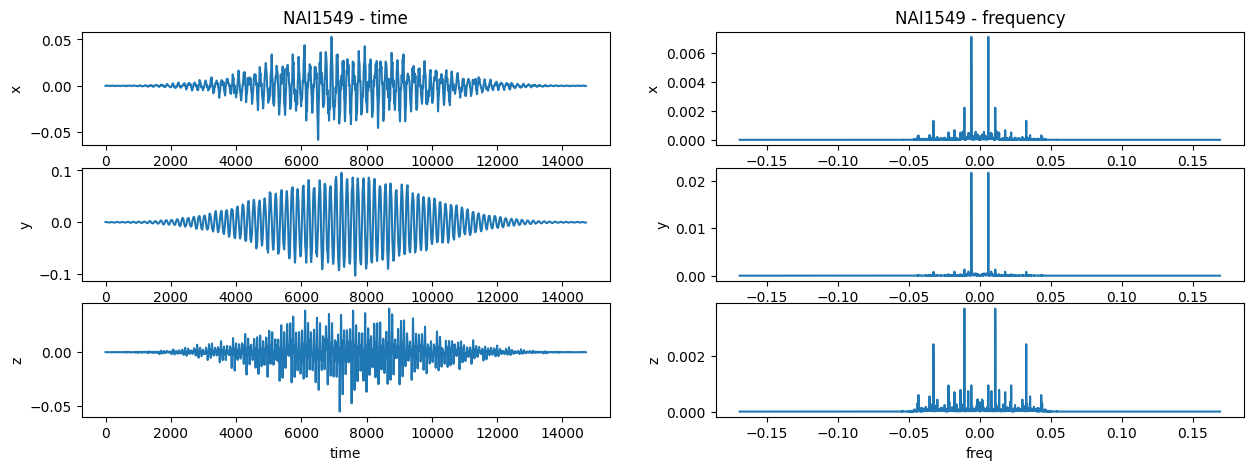

          x         y         z      freq  mult
0  0.007091  0.021730  0.000943  0.005977     1
0  0.000590  0.000215  0.000273  0.011954     2
0  0.000670  0.000850  0.000699  0.017931     3
0  0.000108  0.000050  0.000114  0.023908     4
0  0.000206  0.000171  0.000431  0.029885     5
0  0.000332  0.000155  0.000548  0.035862     6
0  0.000074  0.000055  0.000134  0.041840     7


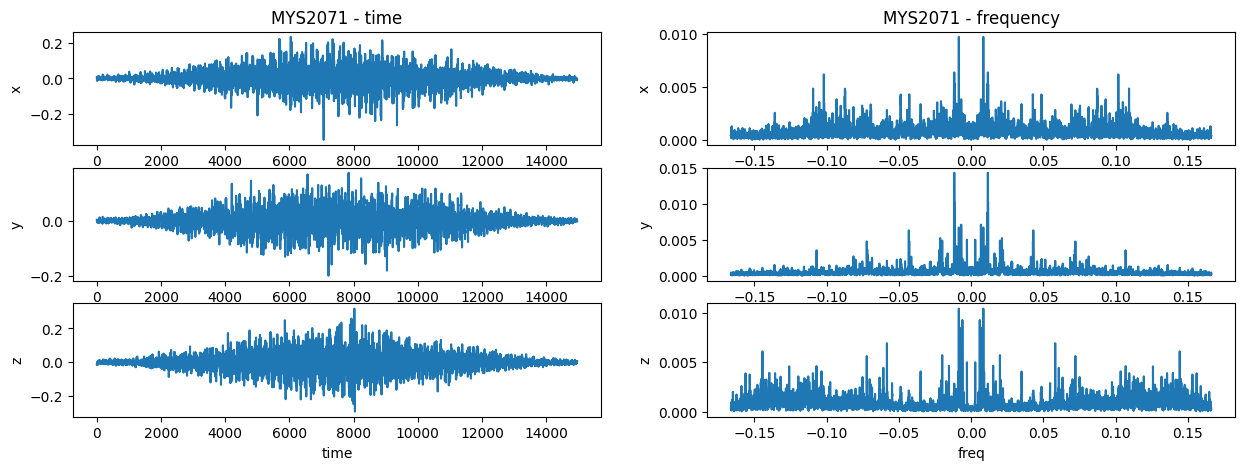

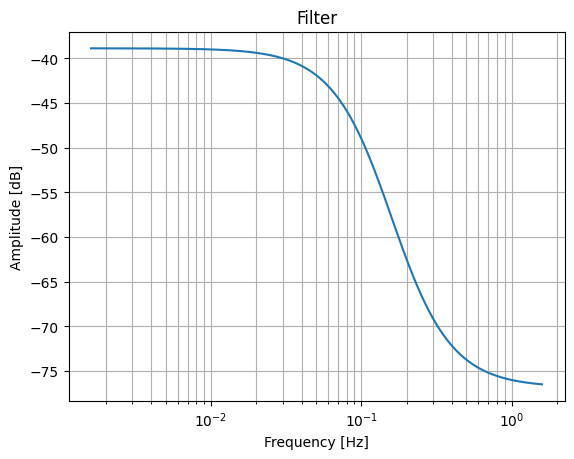

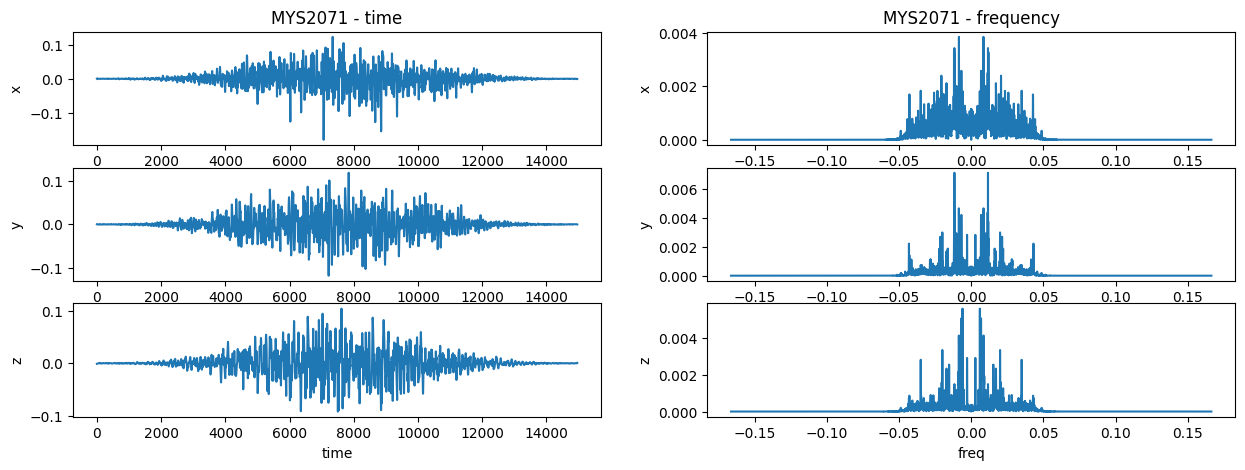

          x         y         z      freq  mult
0  0.001814  0.001321  0.005594  0.006013     1
0  0.003425  0.007131  0.001490  0.012027     2
0  0.000992  0.000509  0.001148  0.018040     3
0  0.001827  0.000677  0.000421  0.024053     4
0  0.001352  0.000407  0.000424  0.030066     5
0  0.000748  0.000474  0.000378  0.036080     6


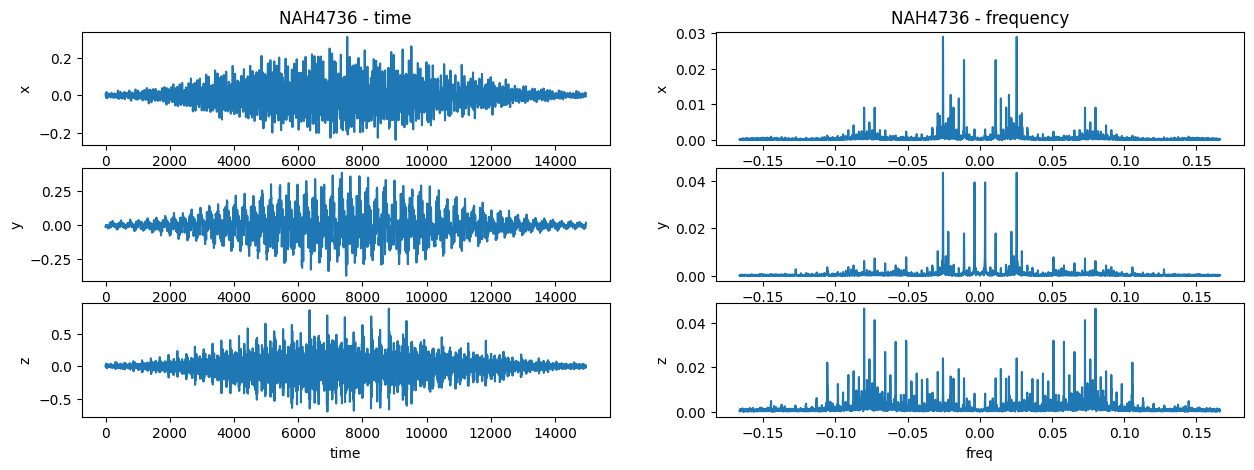

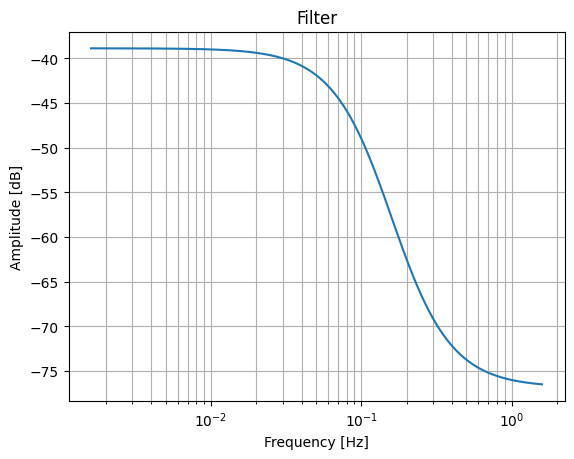

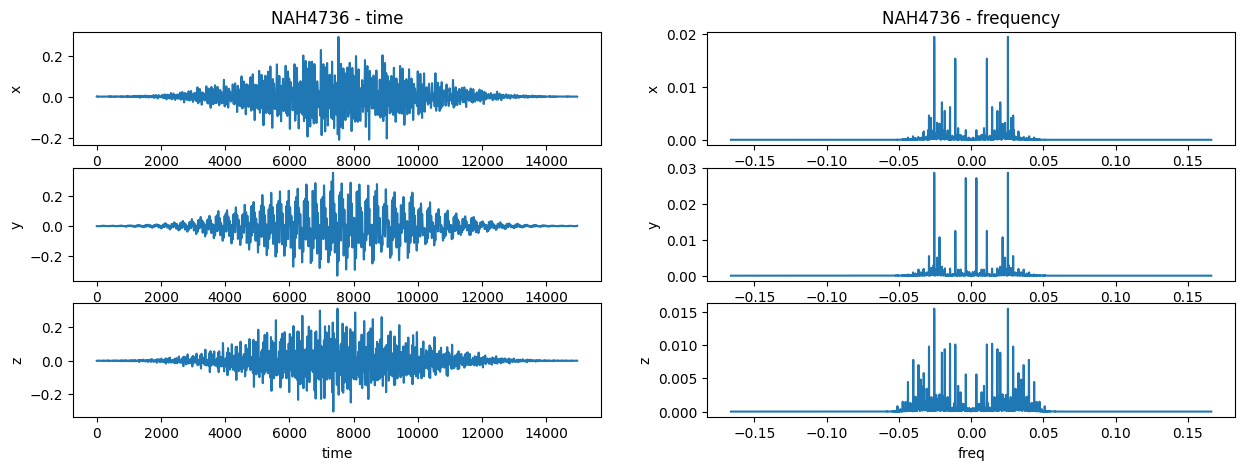

          x         y         z      freq  mult
0  0.019419  0.028708  0.015489  0.025523     1


In [5]:
for idx, filename in enumerate(os.listdir(path_1)):
    signals_dict[idx] = Sensor(path_1, filename)
    signals_dict[idx].freq_signals = signals_dict[idx].fft(signals_dict[idx].time_signals)
    signals_dict[idx].filt_time_signals = signals_dict[idx].filter(signals_dict[idx].time_signals)
    signals_dict[idx].filt_freq_signals = signals_dict[idx].fft(signals_dict[idx].filt_time_signals)
    print(signals_dict[idx].get_harmonics(signals_dict[idx].filt_freq_signals))